# 3 - Model and Evaluation

### Imports and Filtered Data Fetch

In [1]:
import pathlib
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

**Obs:** Just run the followin cell *once* as it alters the working directory path.

In [2]:
# Setting project root directory to work with scripts folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)

print("Current Working Directory:", os.getcwd())    

Current Working Directory: /home/gabrielhso/Desktop/northumbria/data-analytics/project-repo


In [3]:
DATA_DIR = pathlib.Path.cwd() / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
with open(PROCESSED_DATA_DIR / 'filtered.pkl', 'rb') as f:
    all_df, ssh_df, ftp_ssh = pickle.load(f)

all_df.head()

,Tot Fwd Pkts,Tot Bwd Pkts,Flow Duration,Malicious
2018-02-14 01:00:00,13888,17730,35802826873,0
2018-02-14 01:01:00,11909,20098,16922074020,0
2018-02-14 01:02:00,3760,2941,6879804215,0
2018-02-14 01:03:00,6612,10763,8333718014,0
2018-02-14 01:04:00,5708,6130,13561940836,0


In [4]:
X = all_df[["Tot Fwd Pkts", "Tot Bwd Pkts", "Flow Duration"]]
y = all_df["Malicious"]

## Training with all packets

### Splitting data for training and testing

Exploratory analysis shows that there is a particular time where all packet exchange seems null. Let's identify when this hiatus starts

In [5]:
test = all_df[
    (all_df['Tot Fwd Pkts'] == 0) &
    (all_df['Tot Bwd Pkts'] == 0)]
test.index.min(), test.index.max()

(Timestamp('2018-02-14 05:31:00'), Timestamp('2018-02-14 08:27:00'))

Let's use these values as our gap. This way the SSH attack trains the model for identifying the FTP attack.

In [6]:
EXCHANGE_STOP = '2018-02-14 05:31:00'
EXCHANGE_RETURN = '2018-02-14 08:27:00'

X_train = X[X.index < EXCHANGE_STOP].copy()
y_train = y[X.index < EXCHANGE_STOP].copy()

X_test = X[X.index > EXCHANGE_RETURN].copy()
y_test = y[X.index > EXCHANGE_RETURN].copy()

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
svm_model = SVC(kernel="linear", random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       174
           1       0.00      0.00      0.00        98

    accuracy                           0.62       272
   macro avg       0.32      0.49      0.38       272
weighted avg       0.41      0.62      0.49       272


Confusion Matrix:
[[170   4]
 [ 98   0]]


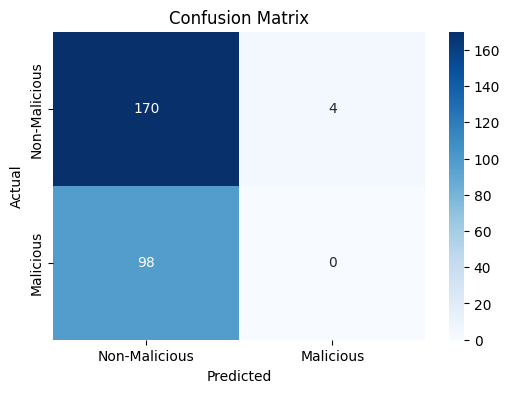

In [9]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Malicious", "Malicious"], yticklabels=["Non-Malicious", "Malicious"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()